Here I'll walk through a cool algorithm that adaptively approximates the column space of a matrix using random projections.

## Background

Imagine we have a matrix ``A`` and that we wish to approximate its column space (i.e. range).
This means finding the space in which the **output** of ``A`` lives.
This can be particularly handy in describing ``A`` when it's too big to store in memory; and, approximating the range is the essential first step of randomized SVD or eigendecompostion.

We're going to find a orthonormal basis ``Q`` that approximates the column space of ``A``.

A modern approach to this problem is to _randomly_ initialize a bunch of vectors $$\Omega$$, then push those vectors through ``A``, $$Y=A\Omega$$, and then orthogonaize the output matrix ``Y``. 
The idea is that ``Y`` is representative of the action ``A`` has on its inputs, and by orthogonalizing ``Y`` to get ``Q``, we get a nice approximation to the basis in which those outputs live.

The problem with this approach is that we need to select the number of vectors in $$\Omega$$ ahead of time.
What if we don't know the dimensionality of the output space, and we want to figure it out iteratively/adaptively?

Ideally, our basis ``Q`` will minimize the exact approximation error $$\text{error(Q)}=\parallel A - QQ^\top A\parallel$$, where the bars are a matrix norm.
If ``Q`` is the true column space of ``A``, then this norm should be zero.

In [105]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_tensor(
    n: int, 
    rank: int
):
    """Define random, fixed-rank nxn matrix"""
    mtx = torch.randn(rank, n)
    u, s, v = torch.svd(mtx)
    s[rank:] = 0  # fix the rank
    s = (s/s.max())**3  # quickly decaying spectrum
    mtx = u @s.diag() @ v.T
    return mtx.T @ mtx

rank_true = 111  # fix rank to 111
m, n = 200, 2000
A = get_tensor(n, rank_true)
A.shape

torch.Size([2000, 2000])

I made a ``2000 x 2000`` matrix whose rank is 111, but we're going to pretend we don't know that and we're trying to find it.
We can plot the spectrum of this matrix below.

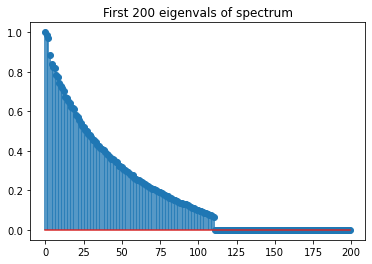

In [106]:
_,s,_=torch.svd(A, compute_uv=False)
fig, ax = plt.subplots(1, 1)
ax.stem(s[:200])
ax.set(title="First 200 eigenvals of spectrum");

## The algorithm

Instead of choosing the dimensionality of ``Q``, we're going to build ``Q`` **iteratively**, one vector at a time.
We typically can't directly compute the approximation error $$\text{error(Q)}=\parallel A - QQ^\top A\parallel$$, because we don't have direct access to ``A``, and only have access to it implicitly via matrix-vector products. 

We begin by drawing a sequence of ``r`` standard Gaussian vectors ``omega`` where ``r`` is a small integer that balances computational cost and reliability.

If we can't compute the exact approximation error directly, we can instead make use of an upper bound where

$$
\left\|\left({I}-{Q} {Q}^{\top}\right) {A}\right\| \leq 10 \sqrt{\frac{2}{\pi}} \max _{i=1, \ldots, r}\left\|\left({I}-{Q} {Q}^{\top}\right) A \omega^{(i)}\right\|
$$

with probability at least $$1-10^{-r}$$.
Even though we won't always have access to ``A`` to compute the left side, we can easily compute the term on the right side.
**In words**, this means that the exact approximation error to the column space of ``A`` is bounded from the top by some constant times the maximum norm of the difference between some vector ``A * omega`` and its ``Q``-projection, ``QQ.T * A * omega``. 
And the more omegas we start with, the higher the probability.

So the idea is that we: 0) start with an empty ``Q``; 1) draw a new Gaussian vector ``omega`` on each iteration; 2) matrix multiply it to get ``y = A * omega`` and store it; 3) orthonormalize it against all previous ``Q``; 4) append to ``Q``.
The moment we get ``r`` consecutive ``y`` vectors whose norms are smaller than some desired threshold, then we can stop.


So by using a series of random projections, we can determine the column space (and therefore the rank) of any arbitrarily large matrix.
More info of this algo can be found in in Halko et al. 2011 (Algo 4.2).
Below is a Python torch implementation with detailed comments.

In [109]:
def adaptive_randomized_range_finder(
    A: torch.Tensor, 
    r: int, tolerance: float, 
    max_iter: int = 200
):
    """Adaptive range finder Algo 4.2 from Halko, Martinsson, Tropp 2011.
    Given an m × n matrix A, a tolerance epsilon, and an integer r
    (e.g. r = 10), this scheme computes an orthonormal matrix Q s.t.
    |(I-Q*Q.T)*A|<= epsilon holds w/ probability
    at least 1 − min{m, n} 10^−r.
    """

    m, n = A.shape
    
    omega = torch.randn(n, r)
    omega, _ = torch.qr(omega)
    y = A @ omega  # y has r vectors
    
    # initial range space estimate (single vector)
    Q = torch.empty(m, 0)
    I = torch.eye(m)
    
    # our threshold is related to our tolerance divided by a fixed constant
    thresh = tolerance / (10*np.sqrt(2/np.pi))
    error_approx = y.norm(dim=0).max()
    loss_approx = []
    loss_true = []
    
    pbar = tqdm(range(max_iter))
    for j in pbar:
        
        if  error_approx <= thresh:
            print("Approximation error thresh or max_iter reached")
            break
        else:

            # reproject onto the range orthog to Q, i.e. (y_j - Q*Q.T*y_j)
            # then overwrite y_j 
            y[:, j] = (I - Q@Q.T) @ y[:, j]
            
            # normalize it and append to Q
            q = y[:,j] / y[:,j].norm()
            Q = torch.cat([Q, q.unsqueeze(-1)], -1)
            
            # draw new gaussian vec
            omega = torch.randn(n, 1)

            # get approximation error = (A @ w - QQ.T @ w)
            y_add = (I - Q @ Q.T) @ (A @ omega)
            
            # append to y's
            y = torch.cat([y, y_add], -1)  
            
            # overwrite j+1:j+r-1 vecs
            y[:, j+1:j+r] = (I - Q @ Q.T) @ y[:, j+1:j+r]
            
            # compute true error (we don't usually have access to this)
            error_true = ((I - Q @ Q.T) @ A).norm(p=2)
            
            # compute error of last r consecutive vecs
            error_approx = y[:, -r:].norm(dim=0).max()  
            
        loss_true.append(error_true)
        loss_approx.append(error_approx)
        pbar.set_postfix({"approx_err": f"{error_approx:.3E}",
                          "true_err": f"{error_true:.3E}"})
    return Q, loss_approx, loss_true

Q_approx, losses_approx, losses_true = adaptive_randomized_range_finder(A, r=10, tolerance=.1, max_iter=150)

 74%|███████▍  | 111/150 [00:21<00:07,  5.28it/s, approx_err=4.382E-05, true_err=2.747E-05]

Approximation error thresh or max_iter reached


## Conclusion:
The algorithm automatically stopped at the intrinsic rank of the matrix (rank=111)!
We successfully used randomized projections to compute the column space of a matrix.
Approximating the range of a matrix is the more difficult step in computing a randomized SVD or eigendecomposition, so  this sets us up nicely for follow-up analyses.

real rank: 111 | computed rank: 111


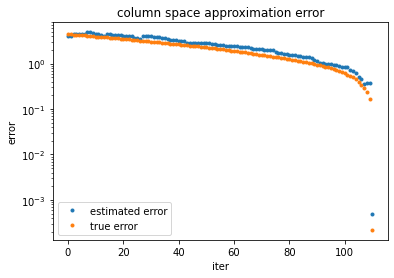

In [108]:
print(f"real rank: {rank_true} | computed rank: {Q_approx.shape[1]}")

fig, ax = plt.subplots(1, 1)
ax.plot(losses_approx, '.', label="estimated error")
ax.plot(losses_true, '.', label="true error")
ax.set(yscale='log', ylabel="error", xlabel='iter', title="column space approximation error")
plt.legend();